# US EPA Air Quality System API Example
This example illustrates how to request data from the US Environmental Protection Agency (EPA) Air Quality Service (AQS) API. This is a historical API and does not provide real-time air quality data. The [documentation](https://aqs.epa.gov/aqsweb/documents/data_api.html) for the API provides definitions of the different call parameter and examples of the various calls that can be made to the API.

This notebook works systematically through example calls, requesting an API key, using 'list' to get various IDs and parameter values, and using 'daily summary' to get summary data that meets specific condistions. The notebook contains example function definitions that could be reused in other code. In general, the notebook explains each step along the way, referring back to possible output. Some of the explanations are tailored to the specific example requests of the API. Changing values to explore the results of the API is probably useful, but that will result in some explanations being out of sync with the outputs.

The US EPA was created in the early 1970's. The EPA reports that they only started broad based monitoring with standardized quality assurance procedures in the 1980's. Many counties will have data starting somewhere between 1983 and 1988. However, some counties still do not have any air quality monitoring stations. The API helps resolve this by providing calls to search for monitoring stations and data using either station ids, or a county designation or a geographic bounding box. This example code provides examples of the county based and bounding box based API calls. Some [additional information on the Air Quality System can be found in the EPA FAQ](https://www.epa.gov/outdoor-air-quality-data/frequent-questions-about-airdata) on the system.

The end goal of this example is to get to some values that we might use for the Air Quality Index or AQI. You might see this reported on the news, most often around smog, but more frequently with regard to smoke. The AQI index is meant to tell us something about how healthy or clean the air is on any day. The AQI is actually a somewhat complext measure. When I started this example I looked up [how to calculate the AQI](https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf) so that I would know roughly what goes into that value.


## License
This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.1 - September 5, 2023

In [1]:
#
#    These are standard python modules
#
#import json, time, urllib.parse
import json, time
#
#    The 'requests' module is a distribution module for making web requests.
#
import requests

In [2]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
#
AQS_REQUEST_TEMPLATE = {
    "email":      "",
    "key":        "",
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}

Example 1. Making a sign-up request
Before you can use the API you need to request a key. You will use an email address to make the request. The EPA then sends a confirmation email link and a 'key' that you use for all other requests.
You only need to sign-up once, unless you want to invalidate your current key (by getting a new key) or you lose your key.

In [3]:
#
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
#
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL,
                   endpoint_action = API_ACTION_SIGNUP,
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):

    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_signup()'")

    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)

    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [ ]:
#
#    A SIGNUP request is only to be done once, to request a key. A key is sent to that email address and needs to be confirmed with a click through
#    This code should probably be commented out after you've made your key request to make sure you don't accidentally make a new sign-up request
#
print("Requesting SIGNUP ...")
response = request_signup("akhark@uw.edu")
print(json.dumps(response,indent=4))
#

Example 2. Making a list request
Once you have a key, the next thing is to get information about the different types of air quality monitoring (sensors) and the different places where we might find air quality stations. The monitoring system is complex and changes all the time. The EPA implementation allows an API user to find changes to monitoring sites and sensors by making requests - maybe monthly, or daily. This API approach is probably better than having the EPA publish documentation that may be out of date as soon as it hits a web page. The one problem here is that some of the responses rely on jargon or terms-of-art. That is, one needs to know a bit about the way atmospheric sciece works to understand some of the terms. ... Good thing we can use the web to search for terms we don't know!

In [5]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL,
                      endpoint_action = API_ACTION_LIST_CLASSES,
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):

    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key

    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']:
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)

    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [6]:
#
#   The default should get us a list of the various groups or classes of sensors. These classes are user defined names for clustors of
#   sensors that might be part of a package or default air quality sensing station. We need a class name to start getting down to the
#   a sensor ID. Each sensor type has an ID number. We'll eventually need those ID numbers to be able to request values that come from
#   that specific sensor.
#

request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

response = request_list_info(request_template=request_data)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))



[
    {
        "code": "AIRNOW MAPS",
        "value_represented": "The parameters represented on AirNow maps (88101, 88502, and 44201)"
    },
    {
        "code": "ALL",
        "value_represented": "Select all Parameters Available"
    },
    {
        "code": "AQI POLLUTANTS",
        "value_represented": "Pollutants that have an AQI Defined"
    },
    {
        "code": "CORE_HAPS",
        "value_represented": "Urban Air Toxic Pollutants"
    },
    {
        "code": "CRITERIA",
        "value_represented": "Criteria Pollutants"
    },
    {
        "code": "CSN DART",
        "value_represented": "List of CSN speciation parameters to populate the STI DART tool"
    },
    {
        "code": "FORECAST",
        "value_represented": "Parameters routinely extracted by AirNow (STI)"
    },
    {
        "code": "HAPS",
        "value_represented": "Hazardous Air Pollutants"
    },
    {
        "code": "IMPROVE CARBON",
        "value_represented": "IMPROVE Carbon Parameters"
    }

In [7]:
#
#   Once we have a list of the classes or groups of possible sensors, we can find the sensor IDs that make up that class (group)
#   The one that looks to be associated with the Air Quality Index is "AQI POLLUTANTS"
#   We'll use that to make another list request.
#
AQI_PARAM_CLASS = "AQI POLLUTANTS"


In [8]:
#
#   Structure a request to get the sensor IDs associated with the AQI
#

request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


We should now have (above) a response containing a set of sensor ID numbers. The list should include the sensor numbers as well as a description or name for each sensor.
The EPA AQS API has limits on some call parameters. Specifically, when we request data for sensors we can only specify a maximum of 5 different sensor values to return. This means we cannot get all of the Air Quality Index parameters in one request for data. We have to break it up.
What I did below was to break the request into two logical groups, the AQI sensors that sample gasses and the AQI sensors that sample particles in the air.

In [9]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"

Air quality monitoring stations are located all over the US at different locations. We will need some sample locations to experiment with different locations to see what kinds of values come back from different sensor requests.
This list includes the FIPS number for the state and county as a 5 digit string. This format, the 5 digit string, is a 'old' format that is still widely used. There are new codes that may eventually be adopted for the US government information systems. But FIPS is currently what the AQS uses, so that's what is in the list as the constant.
Just two example cities to explore.

In [10]:
#
#   I have used my city below to get data
#
CITY_LOCATIONS = {
    'Cladwell' :       {'city'   : 'Cladwell',
                       'county' : 'Canyon',
                       'state'  : 'Idaho',
                       'fips'   : '16027',
                       'latlon' : [43.661766, -116.691559] },
}

Given our CITY_LOCATIONS constant we can now find which monitoring locations are nearby. One option is to use the county to define the area we're interest in. You can get the EPA to list their monitoring stations by county. You can also get a set of monitoring stations by using a bounding box of latitude, longitude points. For this example, we'll use the county approach. There is a bounding box example later in this notebook.

In [11]:
#
#  This list request should give us a list of all the monitoring stations in the county specified by the
#  given city selected from the CITY_LOCATIONS dictionary
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['Cladwell']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['Cladwell']['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "0001",
        "value_represented": null
    },
    {
        "code": "0002",
        "value_represented": "Nampa - Fire Station"
    },
    {
        "code": "0003",
        "value_represented": null
    },
    {
        "code": "0004",
        "value_represented": "NORTHWEST NAZARENE COLLEGE SAMPLER ON ARTS BUILDING IN SUB. SETTING"
    },
    {
        "code": "0005",
        "value_represented": "CALDWELL SYRINGA SCHOOL IN RESIDENTIAL AREA IN NEW GROWTH AREA"
    },
    {
        "code": "0006",
        "value_represented": "MONITOR AT NAMPA PUBLIC LIBRARY,  MAX CONCENTRATION, CANYON SITE"
    },
    {
        "code": "0007",
        "value_represented": null
    },
    {
        "code": "0008",
        "value_represented": null
    },
    {
        "code": "0009",
        "value_represented": null
    },
    {
        "code": "0010",
        "value_represented": "Nampa - Ridgecrest"
    },
    {
        "code": "0400",
        "value_represented": null
   

Example 3. Making a daily summary request
The function below is designed to encapsulate requests to the EPA AQS API. When calling the function one should create/copy a parameter template, then initialize that template with values that won't change with each call. Then on each call simply pass in the parameters that need to change, like date ranges.
Another function below provides an example of extracting values and restructuring the response to make it a little more usable.

In [12]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date.
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL,
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY,
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):

    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']:
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']:
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']:
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']:
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)

    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response




In [13]:
#////////////////////// Test
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_GASEOUS
request_data['state'] = CITY_LOCATIONS['Cladwell']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['Cladwell']['fips'][2:]

In [15]:

request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_GASEOUS
request_data['state'] = CITY_LOCATIONS['Cladwell']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['Cladwell']['fips'][2:]

# request daily summary data for all months
gaseous_aqi = request_daily_summary(request_template=request_data, begin_date="19630101", end_date="19631231")
print("Response for the gaseous pollutants ...")
#
if gaseous_aqi["Header"][0]['status'] == "Success":
    print(json.dumps(gaseous_aqi['Data'],indent=4))
elif gaseous_aqi["Header"][0]['status'].startswith("No data "):
    print("Looks like the response generated no data. You might take a closer look at your request and the response data.")
else:
    print(json.dumps(gaseous_aqi,indent=4))
#---------------------------------------------
request_data['param'] = AQI_PARAMS_PARTICULATES
# request daily summary data for the month of July in 2021
particulate_aqi = request_daily_summary(request_template=request_data, begin_date="20210701", end_date="20210731")
print("Response for the particulate pollutants ...")
#
if particulate_aqi["Header"][0]['status'] == "Success":
    print(json.dumps(particulate_aqi['Data'],indent=4))
elif particulate_aqi["Header"][0]['status'].startswith("No data "):
    print("Looks like the response generated no data. You might take a closer look at your request and the response data.")
else:
    print(json.dumps(particulate_aqi,indent=4))


Streaming output truncated to the last 5000 lines.
    },
    {
        "state_code": "16",
        "county_code": "027",
        "site_number": "0002",
        "parameter_code": "88101",
        "poc": 1,
        "latitude": 43.58031,
        "longitude": -116.562676,
        "datum": "WGS84",
        "parameter": "PM2.5 - Local Conditions",
        "sample_duration_code": "7",
        "sample_duration": "24 HOUR",
        "pollutant_standard": "PM25 Annual 2012",
        "date_local": "2021-07-19",
        "units_of_measure": "Micrograms/cubic meter (LC)",
        "event_type": "Concurred Events Excluded",
        "observation_count": 1,
        "observation_percent": 100.0,
        "validity_indicator": "Y",
        "arithmetic_mean": 29.4,
        "first_max_value": 29.4,
        "first_max_hour": 0,
        "aqi": 87,
        "method_code": "545",
        "method": "Met One E-SEQ-FRM PM2.5 with VSCC - Gravimetric",
        "local_site_name": "Nampa - Fire Station",
        "site_a

In [16]:
#Run code over all yrs and check for data - gaseous
import datetime
import calendar

# Define the start and end years
start_year = 1963
end_year = 2023

# Iterate over the years and months, and make requests for each combination
for year in range(start_year, end_year + 1):
    for month in range(1, 13):  # 1 to 12 for January to December
        begin_date = f"{year}{month:02}01"
        end_date = f"{year}{month:02}{calendar.monthrange(year, month)[1]}"  # Get the last day of the month

        request_data = AQS_REQUEST_TEMPLATE.copy()
        request_data['email'] = USERNAME
        request_data['key'] = APIKEY
        request_data['param'] = AQI_PARAMS_GASEOUS
        request_data['state'] = CITY_LOCATIONS['Cladwell']['fips'][:2]
        request_data['county'] = CITY_LOCATIONS['Cladwell']['fips'][2:]

        gaseous_aqi = request_daily_summary(request_template=request_data, begin_date=begin_date, end_date=end_date)

        print(f"Response for the gaseous pollutants for {datetime.date(year, month, 1).strftime('%B %Y')} ...")

        if gaseous_aqi["Header"][0]['status'] == "Success":
            print(json.dumps(gaseous_aqi['Data'], indent=4))
        elif gaseous_aqi["Header"][0]['status'].startswith("No data "):
            print("Looks like the response generated no data. You might take a closer look at your request and the response data.")
        else:
            print(json.dumps(gaseous_aqi, indent=4))



Streaming output truncated to the last 5000 lines.
        "sample_duration_code": "W",
        "sample_duration": "8-HR RUN AVG BEGIN HOUR",
        "pollutant_standard": "Ozone 8-hour 2015",
        "date_local": "2006-07-18",
        "units_of_measure": "Parts per million",
        "event_type": "No Events",
        "observation_count": 17,
        "observation_percent": 100.0,
        "validity_indicator": "Y",
        "arithmetic_mean": 0.035529,
        "first_max_value": 0.053,
        "first_max_hour": 10,
        "aqi": 49,
        "method_code": "087",
        "method": "INSTRUMENTAL - ULTRA VIOLET ABSORPTION",
        "local_site_name": null,
        "site_address": "5 SOUTH 3RD AVENUE WEST",
        "state": "Idaho",
        "county": "Canyon",
        "city": "Not in a city",
        "cbsa_code": "14260",
        "cbsa": "Boise City, ID",
        "date_of_last_change": "2023-02-05"
    },
    {
        "state_code": "16",
        "county_code": "027",
        "site_number"

In [17]:
#Run code over all yrs and check for data - particulate
import datetime
import calendar

# Define the start and end years
start_year = 1963
end_year = 2023

# Iterate over the years and months, and make requests for each combination
for year in range(start_year, end_year + 1):
    for month in range(1, 13):  # 1 to 12 for January to December
        begin_date = f"{year}{month:02}01"
        end_date = f"{year}{month:02}{calendar.monthrange(year, month)[1]}"  # Get the last day of the month

        request_data = AQS_REQUEST_TEMPLATE.copy()
        request_data['email'] = USERNAME
        request_data['key'] = APIKEY
        request_data['param'] = AQI_PARAMS_PARTICULATES  # Change to particulate AQI
        request_data['state'] = CITY_LOCATIONS['Cladwell']['fips'][:2]
        request_data['county'] = CITY_LOCATIONS['Cladwell']['fips'][2:]

        particulate_aqi = request_daily_summary(request_template=request_data, begin_date=begin_date, end_date=end_date)

        print(f"Response for the particulate pollutants for {datetime.date(year, month, 1).strftime('%B %Y')} ...")

        if particulate_aqi["Header"][0]['status'] == "Success":
            print(json.dumps(particulate_aqi['Data'], indent=4))
        elif particulate_aqi["Header"][0]['status'].startswith("No data "):
            print("Looks like the response generated no data. You might take a closer look at your request and the response data.")
        else:
            print(json.dumps(particulate_aqi, indent=4))

Streaming output truncated to the last 5000 lines.
    },
    {
        "state_code": "16",
        "county_code": "027",
        "site_number": "0002",
        "parameter_code": "88101",
        "poc": 1,
        "latitude": 43.58031,
        "longitude": -116.562676,
        "datum": "WGS84",
        "parameter": "PM2.5 - Local Conditions",
        "sample_duration_code": "7",
        "sample_duration": "24 HOUR",
        "pollutant_standard": "PM25 Annual 1997",
        "date_local": "2023-01-17",
        "units_of_measure": "Micrograms/cubic meter (LC)",
        "event_type": "No Events",
        "observation_count": 1,
        "observation_percent": 100.0,
        "validity_indicator": "Y",
        "arithmetic_mean": 4.6,
        "first_max_value": 4.6,
        "first_max_hour": 0,
        "aqi": 19,
        "method_code": "545",
        "method": "Met One E-SEQ-FRM PM2.5 with VSCC - Gravimetric",
        "local_site_name": "Nampa - Fire Station",
        "site_address": "NAMPA FI

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
        "sample_duration": "24 HOUR",
        "pollutant_standard": "PM25 Annual 2012",
        "date_local": "2023-06-17",
        "units_of_measure": "Micrograms/cubic meter (LC)",
        "event_type": "Events Included",
        "observation_count": 1,
        "observation_percent": 100.0,
        "validity_indicator": "Y",
        "arithmetic_mean": 12.3,
        "first_max_value": 12.3,
        "first_max_hour": 0,
        "aqi": 51,
        "method_code": "545",
        "method": "Met One E-SEQ-FRM PM2.5 with VSCC - Gravimetric",
        "local_site_name": "Nampa - Ridgecrest",
        "site_address": "3730 Ridgecrest Drive",
        "state": "Idaho",
        "county": "Canyon",
        "city": "Nampa",
        "cbsa_code": "14260",
        "cbsa": "Boise City, ID",
        "date_of_last_change": "2023-09-29"
    },
    {
        "state_code": "16",
        "county_code": "027",
        "site_number": "0010",
        "parameter_c

For gaseous pollutants, we have data from July 1983 to 2023 ( but the data is quite irregular and we also observe a lot of missing data) For particulate pollutants, we have data from October 19998 - September 2023
Since, I have more data for particulate pollutants, I will go ahead with particulate year which I am taking as 1999 January - 2023 December.

In [18]:
EXTRACTION_FIELDS = ['sample_duration','observation_count','arithmetic_mean','aqi']

#
#    The function creates a summary record
def extract_summary_from_response(r=None, fields=EXTRACTION_FIELDS):
    ## the result will be structured around monitoring site, parameter, and then date
    result = dict()
    data = r["Data"]
    for record in data:
        # make sure the record is set up
        site = record['site_number']
        param = record['parameter_code']
        #date = record['date_local']    # this version keeps the respnse value YYYY-
        date = record['date_local'].replace('-','') # this puts it in YYYYMMDD format
        if site not in result:
            result[site] = dict()
            result[site]['local_site_name'] = record['local_site_name']
            result[site]['site_address'] = record['site_address']
            result[site]['state'] = record['state']
            result[site]['county'] = record['county']
            result[site]['city'] = record['city']
            result[site]['pollutant_type'] = dict()
        if param not in result[site]['pollutant_type']:
            result[site]['pollutant_type'][param] = dict()
            result[site]['pollutant_type'][param]['parameter_name'] = record['parameter']
            result[site]['pollutant_type'][param]['units_of_measure'] = record['units_of_measure']
            result[site]['pollutant_type'][param]['method'] = record['method']
            result[site]['pollutant_type'][param]['data'] = dict()
        if date not in result[site]['pollutant_type'][param]['data']:
            result[site]['pollutant_type'][param]['data'][date] = list()

        # now extract the specified fields
        extract = dict()
        for k in fields:
            if str(k) in record:
                extract[str(k)] = record[k]
            else:
                # this makes sure we always have the requested fields, even if
                # we have a missing value for a given day/month
                extract[str(k)] = None

        # add this extraction to the list for the day
        result[site]['pollutant_type'][param]['data'][date].append(extract)

    return result

In [20]:
from tqdm import tqdm

average_aqi_per_year = {}
for year in tqdm(range(1999, 2024)):

    year_aqi_count = 0
    year_aqi_sum = 0
    count = 0
    begin_date = f"{year}0101"
    end_date = f"{year}1231"
    # gaseous_aqi = request_daily_summary(request_template=request_data, begin_date=begin_date, end_date=end_date)

    # if gaseous_aqi["Header"][0]['status'].startswith("No data "):
    #     print(f"Looks like the response generated no data for year {begin_date}-{end_date}. You might take a closer look at your request and the response data.")


    request_data['param'] = AQI_PARAMS_PARTICULATES
    # request daily summary data for the month of July in 2021
    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=begin_date, end_date=end_date)
    print("Response for the particulate pollutants ...")


    try:

        if particulate_aqi["Header"][0]['status'].startswith("No data "):
            print(f"Looks like the response generated no datafor year {begin_date}-{end_date}. You might take a closer look at your request and the response data.")



        extract_particulate = extract_summary_from_response(particulate_aqi)
        first_site_location = next(iter(extract_particulate.values()))
        data_for_first_site = first_site_location.get('pollutant_type', {})
        for pollutant_data in data_for_first_site.values():
            year_aqi_data = pollutant_data.get('data', {})
            # Loop through the data for each date in the year
            for date, aqi_list in year_aqi_data.items():
                # print(aqi_list)
                for entry in aqi_list:
                    if entry['aqi']:
                        year_aqi_sum += entry['aqi']
                        year_aqi_count += 1

        # Calculate the average AQI for the year and store it in the dictionary


    except Exception as e:
        print(f"Error processing data for year {year}: {str(e)}")

    # Calculate the average AQI for the year
    if year_aqi_count > 0:
        average_aqi = year_aqi_sum / year_aqi_count
        average_aqi_per_year[year] = average_aqi

  4%|▍         | 1/25 [00:00<00:19,  1.25it/s]

Response for the particulate pollutants ...


  8%|▊         | 2/25 [00:01<00:22,  1.03it/s]

Response for the particulate pollutants ...


 12%|█▏        | 3/25 [00:03<00:25,  1.16s/it]

Response for the particulate pollutants ...


 16%|█▌        | 4/25 [00:04<00:23,  1.13s/it]

Response for the particulate pollutants ...


 20%|██        | 5/25 [00:05<00:23,  1.16s/it]

Response for the particulate pollutants ...


 24%|██▍       | 6/25 [00:06<00:22,  1.16s/it]

Response for the particulate pollutants ...


 28%|██▊       | 7/25 [00:08<00:21,  1.21s/it]

Response for the particulate pollutants ...


 32%|███▏      | 8/25 [00:09<00:20,  1.19s/it]

Response for the particulate pollutants ...


 36%|███▌      | 9/25 [00:10<00:18,  1.18s/it]

Response for the particulate pollutants ...


 40%|████      | 10/25 [00:11<00:16,  1.08s/it]

Response for the particulate pollutants ...


 44%|████▍     | 11/25 [00:11<00:13,  1.02it/s]

Response for the particulate pollutants ...


 48%|████▊     | 12/25 [00:13<00:12,  1.00it/s]

Response for the particulate pollutants ...


 52%|█████▏    | 13/25 [00:13<00:10,  1.10it/s]

Response for the particulate pollutants ...


 56%|█████▌    | 14/25 [00:14<00:09,  1.19it/s]

Response for the particulate pollutants ...


 60%|██████    | 15/25 [00:15<00:07,  1.30it/s]

Response for the particulate pollutants ...


 64%|██████▍   | 16/25 [00:15<00:06,  1.39it/s]

Response for the particulate pollutants ...


 68%|██████▊   | 17/25 [00:16<00:06,  1.19it/s]

Response for the particulate pollutants ...


 72%|███████▏  | 18/25 [00:17<00:06,  1.05it/s]

Response for the particulate pollutants ...


 76%|███████▌  | 19/25 [00:19<00:06,  1.02s/it]

Response for the particulate pollutants ...


 80%|████████  | 20/25 [00:20<00:05,  1.07s/it]

Response for the particulate pollutants ...


 84%|████████▍ | 21/25 [00:22<00:05,  1.44s/it]

Response for the particulate pollutants ...


 88%|████████▊ | 22/25 [00:25<00:05,  1.85s/it]

Response for the particulate pollutants ...


 92%|█████████▏| 23/25 [00:27<00:03,  1.78s/it]

Response for the particulate pollutants ...


 96%|█████████▌| 24/25 [00:28<00:01,  1.72s/it]

Response for the particulate pollutants ...


100%|██████████| 25/25 [00:29<00:00,  1.18s/it]

Response for the particulate pollutants ...


In [21]:
with open('../aqi_by_year.json', 'w') as f:
    json.dump(average_aqi_per_year, f, indent=4)

In [22]:
# Min-max scaling function for lists
def min_max_scale(data):
    min_val = min(data)
    max_val = max(data)
    scaled_data = [(value - min_val) / (max_val - min_val) for value in data]
    return scaled_data


In [24]:
import json

# Assuming your JSON file is named 'data.json'
json_file_path = '/content/yearly_smoke_impacts.json'

# Open and read the JSON file
with open(json_file_path, 'r') as file:
    # Load JSON data into a dictionary
    data_dict = json.load(file)

# Now 'data_dict' contains the dictionary extracted from the JSON file
test=data_dict.copy()


for year, values in test.items():
    if values and isinstance(values, (list, tuple)):  # Check if the values are iterable and not empty
        average_value = sum(values) / len(values)
        test[year] = average_value
    else:
        # Handle the case where the values are not iterable or the list is empty
        test[year] = None



# Assuming your JSON file is named 'data.json'
json_file_path = '../aqi_by_year.json'

# Open and read the JSON file
with open(json_file_path, 'r') as file:
    # Load JSON data into a dictionary
    aqi_data = json.load(file)


# aqi_data = average_aqi_per_year

# Use the updated smoke estimate data for further calculations

# Filter the dictionaries
filtered_yearly_smoke_impacts = {year: impact for year, impact in test.items() if impact >= 20}
filtered_yearly_aqi_impacts = {year: aqi for year, aqi in aqi_data.items() if aqi >= 1}

display(filtered_yearly_smoke_impacts)
display(filtered_yearly_aqi_impacts)

{'1963': 18329.607236030522,
 '1964': 31415.161772889987,
 '1965': 26646.75425716385,
 '1966': 93745.4590979171,
 '1967': 31566.615988188507,
 '1968': 14567.043039623328,
 '1969': 7791.27390125028,
 '1970': 134741.89881487068,
 '1971': 108611.4979006669,
 '1972': 73285.42038473708,
 '1973': 35601.890767870376,
 '1974': 11929.484424601811,
 '1975': 13413.460855343275,
 '1976': 72335.59291239464,
 '1977': 84314.34949754685,
 '1978': 2834.33901989683,
 '1979': 28657.30475573714,
 '1980': 23915.192907315963,
 '1981': 106902.07394632231,
 '1982': 9931.9180937521,
 '1983': 101447.26056033076,
 '1984': 80634.76053126033,
 '1985': 94690.64508639275,
 '1986': 57952.774947335005,
 '1987': 82141.96040186593,
 '1988': 1086806.6849179212,
 '1989': 29768.719847646076,
 '1990': 48406.27484044867,
 '1991': 43704.078755875846,
 '1992': 136100.25543127462,
 '1993': 34262.036240274225,
 '1994': 116120.7237792267,
 '1995': 32123.513052500726,
 '1996': 275086.2148887994,
 '1997': 12700.89440594488,
 '1998'

{'1999': 32.10344827586207,
 '2000': 23.71212121212121,
 '2001': 26.874643874643876,
 '2002': 29.060518731988473,
 '2003': 24.363363363363362,
 '2004': 23.44326241134752,
 '2005': 22.84463276836158,
 '2006': 22.125401929260452,
 '2007': 22.951367781155014,
 '2008': 28.899799599198396,
 '2009': 26.511737089201876,
 '2010': 32.33192516596258,
 '2011': 21.90692124105012,
 '2012': 26.13189448441247,
 '2013': 25.51098901098901,
 '2014': 18.259615384615383,
 '2015': 29.40788267644363,
 '2016': 30.548666186012976,
 '2017': 35.04189189189189,
 '2018': 33.35247524752475,
 '2019': 25.776234567901234,
 '2020': 40.66997026759167,
 '2021': 35.78908554572271,
 '2022': 40.433249370277075,
 '2023': 21.03476245654693}

In [25]:
# Find the common years
years = sorted(set(filtered_yearly_aqi_impacts.keys()).intersection(filtered_yearly_smoke_impacts.keys()))

# Extract values for common years
aqi_values = [filtered_yearly_aqi_impacts[year] for year in years]
smoke_estimate_values = [filtered_yearly_smoke_impacts[year] for year in years]

In [26]:
scaled_aqi_values = min_max_scale(aqi_values)
scaled_smoke_estimate_values = min_max_scale(smoke_estimate_values)

display(scaled_aqi_values)
display(scaled_smoke_estimate_values)

[0.6177426891960092,
 0.24330296668562562,
 0.3844217789059993,
 0.48196038856920753,
 0.27236284345432676,
 0.23130588755958612,
 0.20459369821176468,
 0.1725000146062684,
 0.2093564524542025,
 0.47478874253194797,
 0.36822806901889366,
 0.6279378374341154,
 0.16275091918358517,
 0.35127864511316387,
 0.3235724585460283,
 0.0,
 0.4974605422378595,
 0.5483648458745648,
 0.7488625947652855,
 0.6734770574460848,
 0.3354083066750427,
 1.0]

[0.1336992680177525,
 0.16713837740239176,
 0.015983355048957756,
 0.4704173015655329,
 0.09131580589577473,
 0.006301863011765004,
 0.18842263726370692,
 0.3548551455577957,
 0.39088190904903264,
 0.06108294057945329,
 1.0,
 0.028392327444286106,
 0.2789329993203723,
 0.5077787734293416,
 0.06740684208682986,
 0.11283867101629962,
 0.09511230975298873,
 0.14192144518083752,
 0.4912014699540093,
 0.26519760804513864,
 0.0,
 0.46214010486704493]

Correlation Coefficient: 0.16681949776978586


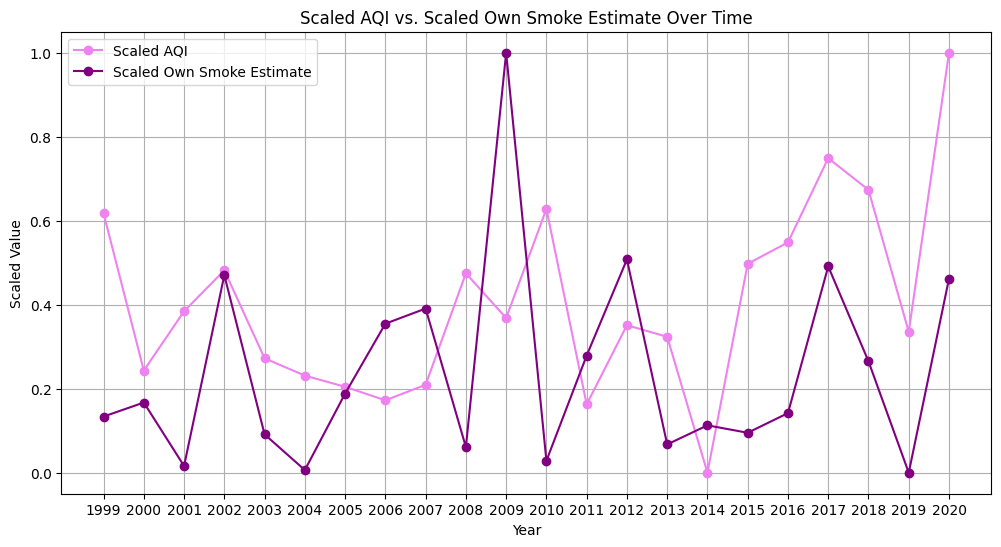

In [29]:
import matplotlib.pyplot as plt

import numpy as np
# Calculate the correlation coefficient
correlation = np.corrcoef(scaled_aqi_values, scaled_smoke_estimate_values)[0, 1]

# Print the correlation coefficient
print(f"Correlation Coefficient: {correlation}")

# Create a line chart to visualize the data
plt.figure(figsize=(12, 6))
plt.plot(years, scaled_aqi_values, label='Scaled AQI', marker='o', linestyle='-', color = 'violet')
plt.plot(years, scaled_smoke_estimate_values, label='Scaled Own Smoke Estimate', marker='o', linestyle='-', color = 'purple')
plt.xlabel('Year')
plt.ylabel('Scaled Value')
plt.title('Scaled AQI vs. Scaled Own Smoke Estimate Over Time')
plt.legend()
plt.grid(True)
plt.show()# Your AQI data
aqi_data = average_aqi_per_year